## コスト関数

このレッスンでは、 *コスト関数* を評価する方法について学びます：

- まず、 [Qiskit Runtime primitives](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/primitives.html) について学びます。
-  *コスト関数* $C(\vec\theta)$ を定義します。これは、オプティマイザーが最小化（または最大化）するための問題の目標を定義する問題固有の関数です。
- Qiskit Runtime primitiveで測定のストラテジーを定義し、速度と精度を最適化します。

&nbsp;

![Cost function workflow](images/cost_function_workflow.png)

## Primitive

古典的なものであれ量子的なものであれ、すべての物理系は異なる状態で存在することができます。例えば、道路を走る車は、その状態を特徴づける特定の質量、位置、速度、または加速度を持つことができます。同様に、量子系も異なる構成や状態を持つことができますが、測定や状態変化の扱い方が古典系と異なります。そのため、 *重ね合わせ* や *エンタングルメント* など、量子力学にしかないユニークな性質が生まれます。車の状態を速度や加速度などの物理的特性で表現できるように、量子系の状態も数学的な対象である *観測量* を用いて表現することができます。

量子力学では、状態は正規化された複素列ベクトル、または *ケット* ( $|\psi\rangle$ )で表され、観測量はケットに作用するエルミート線形演算子( $\hat{H}=\hat{H}^{\dagger}$ ) です。観測量の固有ベクトル ( $|\lambda\rangle$ ) は*固有状態*と呼ばれます。その固有状態( $|\lambda\rangle$ ) の一つで観測量を測定すると、対応する固有値( $\lambda$ )を読み出すことができます。

量子系をどのように測定するのか、何を測定できるのか疑問に思っている方に、Qiskitは2つの [primitive](gloss:primitives) を提供しています：

- `Sampler`: 量子状態 $|\psi\rangle$ が与えられたとき、このprimitiveは、各計算基底状態の確率を求めます。
- `Estimator`: 量子観測量 $\hat{H}$ と状態 $|\psi\rangle$ が与えられたとき、このprimitiveは $\hat{H}$ の期待値を計算します。


### Sampler primitive

 `Sampler`  primitiveは、状態 $|\psi\rangle$ を準備する量子回路がある場合、計算基底で各可能な状態 $|k\rangle$ を得る確率を計算します。つまり以下を計算します：

$$
p_k = |\langle k | \psi \rangle|^2 \quad \forall k \in \mathbb{Z}_2^n \equiv \{0,1,\cdots,2^n-1\},
$$

ここで、 $n$ は量子ビットの数、 $k$ は出力可能なバイナリー文字列 $\{0,1\}^n$ の整数表現（すなわち、整数の基底 $2$ ）です。

 [Qiskit Runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.Sampler.html) の  `Sampler` は、量子デバイス上で回路を複数回実行し、実行ごとに測定を行い、回収したビット列から確率分布を再構築します。実行回数（ *ショット数* ）が多いほど精度の高い結果が得られますが、その分時間と量子リソースが必要になります。

しかし、可能な出力の数は量子ビット数 $n$ （すなわち $2^n$ ）に対して指数関数的に増加するため、 *密な* 確率分布をえるためには、ショット数も同様に指数関数的に増加する必要があります。したがって、 `Sampler` は、 <code>疎な</code> 確率分布に対してのみ効率的です。つまり、ターゲットとする状態 $|\psi\rangle$ は、計算基底状態の線形結合として表現可能でなければならず、項の数は量子ビット数に対して最大でも多項式に増加するものである必要があります

$$
|\psi\rangle = \sum^{\text{Poly}(n)}_k w_k |k\rangle.
$$

また、`Sampler` は、可能な全状態のサブセットを表す回路のサブセクションから確率を取得するように構成することができます。

### Estimator primitive

`Estimator` primitiveは、量子状態 $|\psi\rangle$ に対する観測量 $\hat{H}$ の期待値を計算します。ここで、観測量の確率 $p_\lambda = |\langle\lambda|\psi\rangle|^2$ として表現でき、 $|\lambda\rangle$ は観測量 $\hat{H}$ の固有状態です。期待値とは、状態$ |\psi\rangle$ を測定したときに得られるすべての可能な結果 $\lambda$ （すなわち観測量の固有値）の平均を、対応する確率で重み付けしたものと定義されます：

$$
\langle\hat{H}\rangle_\psi := \sum_\lambda p_\lambda \lambda = \langle \psi | \hat{H} | \psi \rangle
$$

しかし、観測量の期待値を計算することは、その固有基底を知らないことが多いため、必ずしも可能ではありません。[Qiskit Runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.Estimator.html) の `Estimator` は、複雑な代数的処理を用いて、観測量を固有基底がわかっている他の観測量の組み合わせに分解することで、実際の量子デバイスでの期待値を推定します。

簡単に言うと、 `Estimator` は、測定方法が分からない観測量を、 [パウリ演算子](gloss:pauli) と呼ばれるより簡単で測定可能な観測量に分解します。

どんな演算子も $4^n$ 個のパウリ演算子の組み合わせで表すことができます。

$$
\hat{P}_k := 
\sigma_{k_{n-1}}\otimes \cdots \otimes \sigma_{k_0} \quad 
\forall k \in \mathbb{Z}_4^n \equiv \{0,1,\cdots,4^n-1\}, \\
$$

よって

$$
\hat{H} = \sum^{4^n-1}_{k=0} w_k \hat{P}_k
$$

ここで、 $n$ は量子ビット数、 $k_l \in \mathbb{Z}_4 \equiv \{0, 1, 2, 3\}$ (つまり整数の基底 $4$ ) の $k \equiv k_{n-1} \cdots k_0$ であり、 $(\sigma_0, \sigma_1, \sigma_2, \sigma_3) := (I, X, Y, Z)$ です。

この分解を行った後、`Estimator` は各観測量 $\hat{P}_k$ に対して（つまり元の回路から）新しい回路 $V_k|\psi\rangle$ を導出し、計算基底においてパウリ観測量を効果的に *対角化* し、測定します。パウリ観測量を容易に測定できるのは、 $V_k$ を前もって知っているからであり、他の観測量では一般にそうではありません。

各 `{latex} \hat{P}_{k}` について、 `Estimator` は対応する回路を量子デバイス上で複数回実行し、計算基底の出力状態を測定し、各出力 $j$ を得る確率 $p_{kj}$ を計算します。次に、各出力 $j$ に対応する $P_k$ の固有値 $\lambda_{kj}$ を探し、 $w_k$ を掛け、全ての結果を加算して、与えられた状態 $|\psi\rangle$ に対する観測量  $\hat{H}$ の期待値を求めます。

$$
\langle\hat{H}\rangle_\psi = 
\sum_{k=0}^{4^n-1} w_k \sum_{j=0}^{2^n-1}p_{kj} \lambda_{kj},
$$

$4^n$ 個のパウリの期待値を計算するのは非現実的（つまり指数関数的に大きくなる）なので、 `Estimator` は大量の $w_k$ がゼロのとき（つまり *密*ではなく*疎* のPauli分解）だけ効率化できます。形式的には、この計算が *効率的に解ける* ためには、ゼロでない項の数が量子ビット数 $n$ に対して最大で多項式に増加しなければならないと言うことになります： $\hat{H} = \sum^{\text{Poly}(n)}_k w_k \hat{P}_k.$

読者は、確率 [サンプリング](gloss:sampling) も `Sampler` で説明したように効率的である必要があるという暗黙の仮定に気づくかもしれません。つまり、

$$
\langle\hat{H}\rangle_\psi = 
\sum_{k}^{\text{Poly}(n)} w_k \sum_{j}^{\text{Poly}(n)}p_{kj} \lambda_{kj}.
$$

### 期待値算出のためのガイド例

1量子ビット状態 $|+\rangle := H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ とその観測量を以下のように想定します：

$$\hat{H} = 
\begin{pmatrix} 
-1 & 2 \\
2 & -1 \\
\end{pmatrix}$$
$$ = 2X - Z$$

理論的な期待値は $\langle\hat{H}\rangle_+ = \langle+|\hat{H}|+\rangle = 2$ です。

この観測量を測定する方法を知らないので、その期待値を直接計算することはできず、 $\langle\hat{H}\rangle_+ = 2\langle X \rangle_+ - \langle Z \rangle_+ $ と再表現する必要があります。これは、 $\langle+|X|+\rangle = 1$ 、 $\langle+|Z|+\rangle = 0$ であることに注意すれば、同じ結果になることを示すことができます。

 $\langle X \rangle_+$ と $\langle Z \rangle_+$ を直接計算する方法を説明します。 $X$ と $Z$ は交換しない（つまり同じ固有基底を共有しない）ので、同時に測定することはできず、補助回路が必要です：

Original circuit:


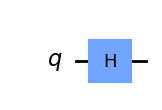

Auxiliary circuit for X


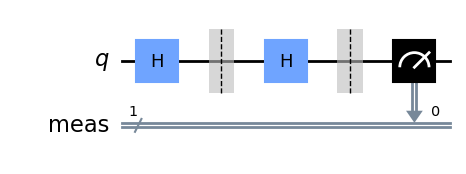

Auxiliary circuit for Z


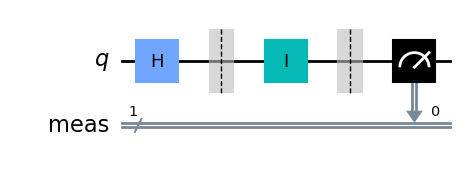

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.i(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)


print("Original circuit:")
display(original_circuit.draw("mpl"))
for (circuit, pauli) in zip(aux_circuits, H.paulis):
    print(f"Auxiliary circuit for {str(pauli)}")
    display(circuit.draw("mpl"))

あとは、 `Sampler` を使って手動で計算を行い、 `Estimator` で結果を確認します：

In [2]:
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit.library import IGate, ZGate
import numpy as np


## SAMPLER
sampler = Sampler()
job = sampler.run(aux_circuits)
probability_dists = job.result().quasi_dists

expvals = []
for dist, pauli in zip(probability_dists, H.paulis):
    val = 0
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    else:
        Lambda = ZGate().to_matrix().real
    val += Lambda[0][0] * dist.get(0, 0)
    val += Lambda[1][1] * dist.get(1, 0)
    expvals.append(val)


print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")


## ESTIMATOR
observables = [
    *H.paulis,
    H,
]  # Note: run for individual Paulis as well as full observable H

estimator = Estimator()
job = estimator.run([original_circuit] * len(observables), observables)
estimator_expvals = job.result().values

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


### 数学的厳密性（オプション）

$|\psi\rangle$ を $\hat{H}$ の固有状態の基底 $|\psi\rangle = \sum_\lambda a_\lambda |\lambda\rangle$ に関して表現すると、次のようになります。

$$
\begin{aligned}
\langle \psi | \hat{H} | \psi \rangle
& = \bigg(\sum_{\lambda'}a^*_{\lambda'} \langle \lambda'|\bigg) \hat{H} 
  \bigg(\sum_{\lambda} a_\lambda | \lambda\rangle\bigg)\\[1mm]

& = \sum_{\lambda}\sum_{\lambda'} a^*_{\lambda'}a_{\lambda} 
  \langle \lambda'|\hat{H}| \lambda\rangle\\[1mm]

& = \sum_{\lambda}\sum_{\lambda'} a^*_{\lambda'}a_{\lambda} \lambda 
\langle \lambda'| \lambda\rangle\\[1mm]

& = \sum_{\lambda}\sum_{\lambda'} a^*_{\lambda'}a_{\lambda} \lambda 
\cdot \delta_{\lambda, \lambda'}\\[1mm]

& = \sum_\lambda |a_\lambda|^2 \lambda\\[1mm]

& = \sum_\lambda p_\lambda \lambda\\[1mm]

\end{aligned}
$$

観測対象 $\hat{H}$ の固有値や固有状態は分からないので、まずその対角化を考える必要があります。 $\hat{H}$ が [エルミート](gloss:hermitian) であることを考えると、$\hat{H}=V^\dagger \Lambda V$ となるようなユニタリー変換 $V$ が存在し、 $\Lambda$ は固有値の対角行列なので、 $j\neq k$ なら $\langle j | \Lambda | k \rangle = 0$ で $\langle j | \Lambda | j \rangle = \lambda_j$　です。

これは、期待値が次のように書き換えられることを意味します：

$$
\begin{aligned}
\langle\psi|\hat{H}|\psi\rangle
& = \langle\psi|V^\dagger \Lambda V|\psi\rangle\\[1mm]

& = \langle\psi|V^\dagger \bigg(\sum_{j=0}^{2^n-1} |j\rangle 
\langle j|\bigg) \Lambda \bigg(\sum_{k=0}^{2^n-1} |k\rangle \langle k|\bigg) V|\psi\rangle\\[1mm]

& = \sum_{j=0}^{2^n-1} \sum_{k=0}^{2^n-1}\langle\psi|V^\dagger |j\rangle 
\langle j| \Lambda  |k\rangle \langle k| V|\psi\rangle\\[1mm]

& = \sum_{j=0}^{2^n-1}\langle\psi|V^\dagger |j\rangle 
\langle j| \Lambda  |j\rangle \langle j| V|\psi\rangle\\[1mm]

& = \sum_{j=0}^{2^n-1}|\langle j| V|\psi\rangle|^2 \lambda_j\\[1mm]

\end{aligned}
$$

確率は $|\psi\rangle$ ではなく、状態 $V |\psi\rangle$ から取られることが非常に重要です。これが行列 $V$ が絶対に必要な理由です。

行列 $V$ と固有値 $\Lambda$ をどうやって求めるのか、疑問に思うかもしれません。もし、すでに固有値があれば、変分アルゴリズムの目的はこの $\hat{H}$ の固有値を求めることなので、量子コンピューターを使う必要はないでしょう。

幸い、それを回避する方法があります：任意の $2^n \times 2^n$ 行列は、 $n$ 個のパウリ行列と恒等演算子の $4^n$ 個のテンソル積の線形結合として書くことができ、これらはすべて、既知の $V$ と $\Lambda$ を持つエルミート行列でありユニタリー行列です。  これが、Runtimeの `Estimator` が内部で行っていることで、`Estimator` は任意の [Operator](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Operator.html) オブジェクトを[SparsePauliOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html) に分解しています。

ここでは、使用可能な演算子を紹介します：

$$
\begin{array}{c|c|c|c}
  \text{Operator} & \sigma & V & \Lambda \\[1mm]
  \hline
  I & \sigma_0 = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} & V_0 = I & \Lambda_0 = I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \\[4mm]

  X & \sigma_1 = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} & V_1 = H =\frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} & \Lambda_1 = \sigma_3 = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} \\[4mm]

  Y & \sigma_2 = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} & V_2 = HS^\dagger  =\frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}\cdot  \begin{pmatrix} 1 & 0 \\ 0 & -i \end{pmatrix} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & -i \\ 1 & i \end{pmatrix}\quad & \Lambda_2 = \sigma_3 = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} \\[4mm]

  Z & \sigma_3 = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} & V_3 = I & \Lambda_3 = \sigma_3 = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
\end{array}
$$

では、 $\hat{H}$ をパウリ演算子と恒等演算子に関して書き換えてみましょう：

$$
\hat{H} = 
\sum_{k_{n-1}=0}^3...
\sum_{k_0=0}^3 w_{k_{n-1}...k_0} 
\sigma_{k_{n-1}}\otimes ... \otimes \sigma_{k_0} = \sum_{k=0}^{4^n-1} w_k \hat{P}_k,
$$

ここで、 $k = \sum_{l=0}^{n-1} 4^l k_l \equiv k_{n-1}...k_0$ は  $k_{n-1},...,k_0\in \{0,1,2,3\}$ (つまり基底 $4$ )であり、`{latex} \hat{P}_{k} := \sigma_{k_{n-1}}\otimes ... \otimes \sigma_{k_0}`:

$$
\begin{aligned}
\langle\psi|\hat{H}|\psi\rangle
& = \sum_{k=0}^{4^n-1} w_k 
\sum_{j=0}^{2^n-1}|\langle j| V_k|\psi\rangle|^2 \langle j| \Lambda_k |j\rangle \\[1mm]

& = \sum_{k=0}^{4^n-1} w_k \sum_{j=0}^{2^n-1}p_{kj} \lambda_{kj}, \\[1mm]


\end{aligned}
$$

ここで $V_k := V_{k_{n-1}}\otimes ... \otimes V_{k_0}$ と $\Lambda_k := \Lambda_{k_{n-1}}\otimes ... \otimes \Lambda_{k_0}$ は $\hat{P_k}=V_k^\dagger \Lambda_k V_k$ です。

## コスト関数

一般に、コスト関数は、問題のゴールと、そのゴールに対して試行状態がどの程度うまくいっているかを記述するために使用されます。この定義は、化学、機械学習、金融、最適化など、さまざまな例に適用することができます。

あるシステムの基底状態を求めるという簡単な例を考えてみましょう。我々の目的は、エネルギーを表す観測量（ハミルトニアン $\hat{\mathcal{H}}$ ）の期待値を最小化することです：

$$
\min_{\vec\theta} \langle\psi(\vec\theta)|\hat{\mathcal{H}}|\psi(\vec\theta)\rangle
$$

[*Estimator* primitive](https://github.com/qiskit-community/prototype-zne/blob/main/docs/tutorials/0-estimator.ipynb) を使用して期待値を評価し、この値をオプティマイザーに渡して最小化することができます。最適化が成功すれば、最適なパラメーター値のセット $\vec\theta^*$ が返され、そこから提案された解の状態 $|\psi(\vec\theta^*)\rangle$ を構築し、観測された期待値を $C(\vec\theta^*)$ として計算することができるようになります。

私たちが考えている状態の限られたセットに対してのみ、コスト関数を最小化することができることに注目してください。このことから、2つの別々の可能性があることがわかります：

- **我々のansatzが、探索空間全体で解の状態を定義していない**: この場合、オプティマイザーは解を見つけることができないので、探索空間をより正確に表現できるかもしれない他のansatzを試してみる必要があります。
- **オプティマイザーが、有効な解を見つけることができない**: 最適化には、大域的な定義と局所的な定義があります。この意味については、後のセクションで説明します。

全体として、私たちは古典的な最適化ループを実行しますが、コスト関数の評価を量子コンピューターに依存することになります。この観点から、最適化は純粋に古典的な取り組みであり、オプティマイザーがコスト関数を評価する必要があるたびに、 [*ブラックボックスの量子オラクル*](gloss:oracle) を呼び出すと考えることができます。

In [3]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum")

def cost_function_vqe(theta):
    observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

    reference_circuit = QuantumCircuit(2)
    reference_circuit.x(0)

    variational_form = TwoLocal(
        2,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
    )
    ansatz = reference_circuit.compose(variational_form)

    backend = service.backend("ibmq_qasm_simulator")
    
    # Use estimator to get the expected values corresponding to each ansatz
    estimator = Estimator(session=backend)
    job = estimator.run(ansatz, observable, theta)
    values = job.result().values

    return values


theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
cost_function_vqe(theta_list)

base_primitive._run_primitive:INFO:2023-11-26 07:19:42,435: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


array([-0.1745])

### 物理でないシステムへのマッピング例

マックスカット（Max-Cut）問題とは、グラフの頂点を2つの不連続な集合に分割し、その2つの集合間の辺の数が最大になるようにする組合せ最適化問題です。より正式には、 $V$ が頂点の集合、 $E$ が辺の集合である無向グラフ $G=(V,E)$ が与えられたとき、マックスカット問題は、頂点を2つの不連続な部分集合、 $S$ と$T$ Tに分割する際に、一方の端点が $S$ にあり他方が $T$ にあるような辺の数が最大となるように求めます。

マックスカットを応用して、クラスタリング、ネットワーク設計、相転移など様々な問題を解くことができます。まず、問題グラフを作成することから始めます：

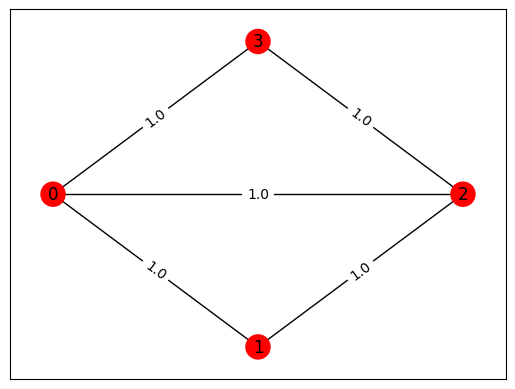

In [4]:
import networkx as nx

n = 4
G = nx.Graph()
G.add_nodes_from(range(n))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(edge_list)

colors = ["red" for i in range(n)]


def draw_graph(G, colors):
    """Draws the graph with the chose colors"""
    layout = nx.shell_layout(G)
    nx.draw_networkx(G, node_color=colors, pos=layout)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)


draw_graph(G, colors)

この問題は、2値最適化問題として表現できます。各  $0 \leq i < n$ （ $n$ はグラフのノード数で、この場合 $n=4$ ）に対して、バイナリー変数 $x_i$ を考えます。この変数は、ノード $i$ が $1$ のラベルを貼ったグループの1つであれば値 $1$ を持ち、 $0$ とラベルを貼った他のグループの1つであれば値 $0$ を持つことになります。また、ノード $i$ からノード $j$ に至るエッジの重みを $w_{ij}$ （隣接行列 $w$の要素 $(i,j)$ ）とします。グラフは無向性なので、 $w_{ij}=w_{ji}$ となります。そうすると、問題は以下のコスト関数を最大化するものとして定式化できます：

$$
\begin{aligned}
C(\vec{x})
& =\sum_{i,j=0}^n w_{ij} x_i(1-x_j)\\[1mm]

& = \sum_{i,j=0}^n w_{ij} x_i - \sum_{i,j=0}^n w_{ij} x_ix_j\\[1mm]

& = \sum_{i,j=0}^n w_{ij} x_i - \sum_{i=0}^n \sum_{j=0}^i 2w_{ij} x_ix_j
\end{aligned}
$$

この問題を量子コンピューターで解決するために、コスト関数を観測量の期待値として表現することになります。しかし、Qiskitがネイティブで認める観測量は、固有値が $0$ と $1$ ではなく $1$ と $-1$ であるパウリ演算子で構成されているため、以下のように変数を変更します：

ここで、 $\vec{x}=(x_0,x_1,\cdots ,x_{n-1})$ です。隣接行列 $w$ を使って、すべてのエッジの重みに快適にアクセスすることができます。これはコスト関数を求めるのに使われます：

$$
z_i = 1-2x_i \rightarrow x_i = \frac{1-z_i}{2}
$$

これはつまり、

$$
\begin{array}{lcl} x_i=0 & \rightarrow & z_i=1 \\ x_i=1 & \rightarrow & z_i=-1.\end{array}
$$

よって私たちが最大化したいコスト関数は新たに

$$
\begin{aligned}
C(\vec{z})
& = \sum_{i,j=0}^n w_{ij} \bigg(\frac{1-z_i}{2}\bigg)\bigg(1-\frac{1-z_j}{2}\bigg)\\[1mm]

& = \sum_{i,j=0}^n \frac{w_{ij}}{4} - \sum_{i,j=0}^n \frac{w_{ij}}{4} z_iz_j\\[1mm]

& = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} -  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} z_iz_j
\end{aligned}
$$

さらに、量子コンピューターの自然な傾向として、最大値ではなく最小値（通常は最低エネルギー）を見つけるので、 $C(\vec{z})$ を最大化するのではなく、最小化します：

$$
-C(\vec{z}) =  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} z_iz_j -  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}
$$

ここで、最小化するコスト関数があり、その変数は $-1$ と $1$ の値を持つので、パウリ $Z$ について、以下のアナロジーを使えます：

$$
z_i \equiv Z_i = \overbrace{I}^{n-1}\otimes ... \otimes \overbrace{Z}^{i} \otimes ... \otimes \overbrace{I}^{0}
$$

つまり、変数 $z_i$ は、量子ビット $i$ に作用する $Z$ ゲートに相当することになります：

$$
Z_i|x_{n-1}\cdots x_0\rangle = z_i|x_{n-1}\cdots x_0\rangle \rightarrow \langle x_{n-1}\cdots x_0 |Z_i|x_{n-1}\cdots x_0\rangle = z_i
$$

そうすると、考えている観測量は以下のように書くことができ：

$$
\hat{H} = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} Z_iZ_j
$$

であり、その後に独立した項を追加する必要があります：

$$
\texttt{offset} = - \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}
$$

この変換は、[`QuadraticProgram.to_ising()`](https://qiskit.org/documentation/optimization/stubs/qiskit_optimization.QuadraticProgram.to_ising.html)で行うことができます。

In [ ]:
from qiskit_optimization.applications import Maxcut
from qiskit.algorithms.optimizers import COBYLA

w = nx.to_numpy_array(G)

max_cut = Maxcut(w)
quadratic_program = max_cut.to_quadratic_program()
observable, offset = quadratic_program.to_ising()


def cost_function_max_cut_vqe(theta):

    ansatz = TwoLocal(
        observable.num_qubits, "rx", reps=1
    )

    backend = service.backend("ibmq_qasm_simulator")

    # Use estimator to get the expected values corresponding to each ansatz
    estimator = Estimator(session=backend)
    job = estimator.run(ansatz, observable, theta)
    values = job.result().values

    return values


optimizer = COBYLA()

initial_theta = np.ones(8)

optimizer_result = optimizer.minimize(fun=cost_function_max_cut_vqe, x0=initial_theta)

optimal_parameters = optimizer_result.x
print(optimal_parameters)

base_primitive._run_primitive:INFO:2023-11-26 07:19:50,238: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-26 07:19:54,197: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans

この例をアプリケーションで再確認し、オプティマイザーを活用して探索空間を反復する方法を探ります。一般的には、以下のようなことが挙げられます：

- オプティマイザーを活用して最適なパラメーターを見つける。
- 固有値を求めるための最適なパラメーターをansatzにバインドする。
- 固有値を我々の問題定義に置き換える。

## 測定の戦略：スピード対精度

すでに述べたように、ノイズの多い量子コンピューターを*ブラックボックスのオラクル*として使用しているため、ノイズによって取得される値が非決定的になり、ランダムな揺らぎが生じて、特定のオプティマイザーが提案した解に収束するのを阻害される、あるいは完全に妨害されることがあります。これは、量子的な利点を得るために段階的に進歩していく中で、私たちが対処しなければならない一般的な問題です：

![Advantage](images/cost_function_path_to_quantum_advantage.png)

Qiskit Runtime Primitiveのエラー抑制・エラー緩和オプションを利用してノイズに対応することで、今日の量子コンピューターの実用性を最大化することができます。

### エラー抑制

[エラー抑制](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-suppression.html) とは、コンパイル時に回路を最適化して変換し、エラーを最小化するために使用する技術のことです。これは基本的なエラー処理技術であり、通常、ランタイム全体に対する古典的な前処理 [オーバーヘッド](gloss:overhead) をもたらします。このオーバーヘッドには、以下のような量子ハードウェア上で動作するように回路をトランスパイルすることが含まれます：

- 量子システムで実行できるネイティブゲートで回路を表現する。
- 仮想量子ビットを物理量子ビットにマッピングする。
- コネクティビティの要件に基づくSWAPの追加。
- 1Qと2Qのゲートを最適化する。
- アイドルの量子ビットに動的デカップリングを追加し、デコヒーレンスの影響を防ぐ。

Primitiveは、 <a>optimization_level</a> オプションを設定し、高度なトランスパイルオプションを選択することで、[エラー抑制技術](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-suppression.html)  を使用することができます。この後のコースで、結果を改善するためのさまざまな回路構築方法を掘り下げますが、ほとんどの場合、`optimization_level=3` を設定することをお勧めします。

### エラー緩和

[エラー緩和](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html) とは、実行時にデバイスのノイズをモデル化することで、回路エラーを低減させる技術を指します。一般的に、モデルのトレーニングに関連する量子的な前処理オーバーヘッドと、生成されたモデルを使用して生の結果のエラーを軽減するための古典的な後処理オーバーヘッドが発生することになります。

Qiskit Runtime primitiveの `resilience_level` オプションは、エラーに対して構築する回復力の量を指定します。レベルが高いほど、量子サンプリングのオーバーヘッドによる処理時間の長さを犠牲にして、より正確な結果を生成します。レジリエンスレベルは、primitiveのクエリにエラー緩和を適用する際に、コストと精度のトレードオフを設定するために使用されます。

どのようなエラー緩和技術を実装する場合でも、結果の [偏り](gloss:bias) は、以前の、緩和されていない偏りに対して減少することが期待されます。場合によっては、偏りが消えることさえあります。しかし、これには代償が伴います。推定量の偏りを減らすと、統計的なばらつき（つまり分散）が大きくなりますが、これはサンプリングプロセスで回路ごとのショット数をさらに増やすことで説明できます。この場合、偏りを減らすために必要な以上のオーバーヘッドが発生するため、デフォルトではこの動作は行われません。以下の例のように、options.executions.shotsで回路あたりのショット数を調整することで、この操作は、簡単に導入できます。

![Bias Variance Trade-off](images/cost_function_bias_variance_trade_off.png)

このコースでは、これらのエラー緩和モデルを高いレベルで探求し、完全な実装の詳細を必要とせずに、Qiskit Runtime primitiveが実行できるエラー緩和を説明します。

### トワイル読み出しエラー消去法 (T-REx)

トワイル読み出しエラー消去法 (Twirled Readout Error eXtinction, T-REx) は、パウリトワリングとして知られる技法を用いて、量子測定の過程で導入されるノイズを低減します。この手法は、特定の形態のノイズを想定していないため、非常に汎用的で効果的です。

全体のワークフロー:

1. ランダム化されたビットフリップを使用してゼロ状態のデータを取得します (測定前のパウリ X)。
2. ランダム化されたビットフリップを使用して目的の (ノイズの多い) 状態のデータを取得します (測定前のパウリ X)。
3. 各データセットの特殊関数を計算し、除算します。

&nbsp;

![TRE-X](images/cost_function_trex_data_collection.png)

以下の例では、 `options.resilience_level = 1`で設定することができます。

### ゼロ・ノイズ外挿

ゼロノイズ外挿（ZNE）は、まず目的の量子状態を準備する回路のノイズを増幅し、いくつかの異なるレベルのノイズの測定値を得て、その測定値を用いてノイズのない結果を推論することで機能します。

全体のワークフロー:

1. いくつかのノイズ要因に対して回路ノイズを増幅する
2. すべてのノイズ増幅回路を実行する
3. ゼロノイズ限界に外挿する

&nbsp;

![ZNE](images/cost_function_zne_stages.png)

これは `options.resilience_level = 2` で設定することができます。`noise_factors`, `noise_amplifiers`, `extrapolators` をいろいろと試すことで、さらに最適化できますが、これはこの講義コースの範囲外です。ぜひ、  [ここに書かれているようなオプション](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html#advanced-resilience-options) を使って実験してみてください。

### 確率的エラー・キャンセル

確率的エラー・キャンセル（PEC）は、平均的にノイズ反転チャネルを模倣する回路のコレクションをサンプリングして、目的の計算のノイズを打ち消します。このプロセスは、ノイズキャンセリングヘッドフォンの仕組みに少し似ており、素晴らしい結果をもたらしますが、他の方法ほど一般的ではなく、サンプリングのオーバーヘッドが指数関数的です。

全体のワークフロー:

![PEC](images/cost_function_pec_layers.png)

ステップ 1: パウリトワリング

![PEC Twirling](images/cost_function_pec_pauli_twirling.png)

ステップ 2: レイヤーを繰り返したノイズの学習

![PEC Learning](images/cost_function_pec_learn_layer.png)

ステップ 3: 忠実度の導出 (各ノイズ・チャネルの誤差)

![PEC Fidelity](images/cost_function_pec_curve_fitting.png)

それぞれの方法には、量子計算の回数（時間）と結果の精度のトレードオフという、関連するオーバーヘッドがあります：

$$
\begin{array}{c|c|c|c}
  \text{Methods} & R=1 \text{, T-REx} & R=2 \text{, ZNE} & R=3 \text{, PEC} \\[1mm]
  \hline
  \text{Assumptions} & \text{None} & \text{Ability to scale noise} & \text{Full knowledge of noise} \\[1mm]
  \text{Qubit overhead} & 1 & 1 & 1 \\[1mm]
  \text{Sampling overhead} & 2 & N_{\text{noise-factors}} & \mathcal{O}(e^{\lambda N_{layers}}) \\[1mm]
  \text{Bias} & 0 & \mathcal{O}(\lambda^{N_{\text{noise-factors}}}) & 0 \\[1mm]
\end{array}
$$

### Qiskit Runtimeの緩和・抑制オプションの使い方

Qiskit Runtimeでエラー緩和と抑制を使用しながら、期待値を計算する方法を紹介します。このプロセスは最適化ループの中で何度も発生しますが、エラー緩和と抑制の設定方法を示すために、この例はシンプルにしています。

In [ ]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl")

In [ ]:
## Setup phases
import numpy as np

phases = np.linspace(0, 2 * np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

In [ ]:
## Create noise model
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import Options


# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42,
}

In [ ]:
from qiskit_ibm_runtime import Session, QiskitRuntimeService, Estimator

# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum")

noisy_exp_values = []
exp_values_with_em_es = []

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    # generate noisy results
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    noisy_exp_values = result.values

    options.optimization_level = 2
    options.resilience_level = 1

    # leverage mitigation and suppression
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    exp_values_with_em_es = result.values

    session.close()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_values, "o", label="Noisy")
plt.plot(phases, exp_values_with_em_es, "o", label="Mitigation + Suppression")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="Theory")
plt.xlabel("Phase")
plt.ylabel("Expectation")
plt.legend()
plt.show()

このレッスンでは、コスト関数を作成する方法について学びました：

- コスト関数を作成する
- [Qiskit Runtime primitives](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/primitives.html) を活用してノイズを軽減・抑制する方法
- スピードと精度を最適化するための測定戦略の定義方法

このハイレベルな変分の作業は次のようになります：

![Cost Function Circuit](images/cost_function_circuit.png)

このコスト関数は、最適化ループの各繰り返しで実行されます。次のレッスンでは、古典的なオプティマイザーが新しいパラメーターを選択するために、コスト関数の評価をどのように利用するかを探ります。